# Ocean temperature forecast analysis 

## Introduction :

*Today satellites provide a surface signature of the temperature with a high spatial frequency: ie a good horizontal resolution but a low vertical resolution.Thanks to the ARGO database collected by buoys making vertical surveys, one has a precise but sparse knowledge of the vertical thermal structure of the ocean. The objective of this project is to develop a methodology to statistically combine additional information to obtain a 3D time series sufficiently resolved horizontally and vertically to follow the eddies.
It is based on a regression classification method that allows both to classify the temperature profiles and to propose a linear model between the satellite observations and the information of the buoys according to its label.*


## Theory and model : 

Temperature profiles can be approximated linearly from satellite surfacic data with coefficient that varies according to the class surfacic data belongs known as a latent mode. Given Y the temperature profile in depth and X the surfacic data, Z the latent mode we obtain :

$$ Y|_{X,Z=k}= \mathcal{N}(X \beta_k, \Sigma_k)$$

With $ \beta_k$ the linear coefficient and $\Sigma_k$ covariance matrix.

**Sattelite data available :**

- patches of 13x13 SST

Sea surface temperature (SST) is the water temperature close to the ocean's surface. Surface here means between 1 millimetre (0.04 in) and 20 metres (70 ft) below the sea surface.
SST changes diurnally, like the air above it, but to a lesser degree. There is less SST variation on breezy days than on calm days.
 
- patches of 13x13 SLA

Sea Level Anomalies (SLA) are provided along-track for all available satellite altimeter missions. They describe the difference between the actual sea surface height (SSH) and a mean sea surface height (MSSH). All measurements are already corrected by the most actual geophysical corrections (e.g. tides and atmospheric delays).

**ARGO Data :** 
- Temperature profiles (36 depth levels) from the surface down to about -1000m. This is in the variable "TEMP" 
- The classification result of the profile. It's an integer between 1 and 4, in the variable "LABEL" 

Profile labels are taken from Guillaume Maze publication:  *A Profile Classification Model from North-Atlantic Argo temperature data.* SEANOE Sea scientific open data edition / One may found it's GitHub here :[obidam/pcm](https://github.com/obidam/pcm).

They will be used to qualitatively evaluate the clusterization process.

**Additional data:** 

- Coordinates of each patch points are in "lat" and "lon". The grid is not regular, so each patch point has its own latitude and longitude.
- The date of the profile is in "tim" and the depth levels of the profile in "dpt".
- There are "n_obs" samples for each of these.


### Parametrization :

We want to constraint ourself to work with a realistic number of data. Let's assume we have 706 profiles. If we do not apply dimension reduction techniques, our model will need to fit : 

$$ N_{param} = N_{class} (N_{features}N_{Target} + N_{COV}) $$
$$ N_{param} = 4* ((13*13 + 13*13) *36 + 36^2)  = 53856$$

So at least 53856/36 = 1496 profiles so that the number of equation is equal to the number of parameter to select.

Which will surely lead to overfitting if trained with 706 profiles.


**Dimension Reduction : Principal Component Analysis (PCA)**

PCA are realized on both feature and target vectors:  0.99 % of the variance is kept for both.

**Selecting the number of mode: Bayesian Information Criterion (BIC)**

*In statistics, the Bayesian information criterion (BIC) is a criterion for model selection among a finite set of models; the model with the lowest BIC is preferred. It is based on the likelihood function and on the number of parameters of the model involved. When fitting models, it is possible to increase the likelihood by adding parameters, but doing so may result in overfitting. BIC  attempts to resolve this problem by introducing a penalty term for the number of parameters in the model; the penalty term is larger in BIC.*

In our case, the Bayesian Information Criterion (BIC) is calculted given the following formula :

<img src="https://latex.codecogs.com/svg.latex?\Large&space;BIC=-2*log(lik)+n_{params}*log(size_{samples})" title="BIC" />

We compute the BIC to choose how many modes we should identify. 

Here 3 or 4 modes have been identified as optimal.

**Convergence to the best solution :**

We realize several EM algorithm realizing clusterization + regression fitting.

To combine several simulations we need to re-assign labels first : to do so we minimize chamfer distance on the latitude, longitude corresponding to each label. 

Once the labels re-assigned, we have for each sample different labelization, we take the most frequent and hardcode it as the combined_label.

Finally we initialize a new EM with the labels obtained by combination.

### Generating prediction :

Now that we have fitted $\beta_k$ and $\Sigma_k$, we can make a prediction knowing a label/mode.
The infimum of error can now be computed.

**How to estimate the mode :**

In practice we have to estimate the right mode, to do so we estimate the probability density function of each class.

Then for each sample we consider it's mode is the one corresponding to the highest pdf value.

**RMS heatmap are computed at the end**


In [192]:
import warnings
warnings.filterwarnings('ignore')

%config IPCompleter.greedy=True
# load numpy and matplotlib
%pylab inline
pylab.rcParams['figure.figsize']=(8.0,8.0)

from sklearn.cluster import KMeans
import numpy as np
import tqdm
import os
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import func
import scipy.stats
from scipy.linalg import qr, solve, lstsq
from scipy.stats import multivariate_normal

from numpy import *
from IPython.display import Image
from IPython.core.display import HTML
import library as lib
import random as rd
import matplotlib.image as mpimg
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


### Load patches : 

The netcdf file contains:  
- Temperature profiles (36 depth levels) from the surface down to about -1000m. This is in the variable "TEMP"
- The classification result of this profile. It's an integer between 1 and 4, in the variable "LABEL"
- A patch of Sea Surface Temperature centered on the temperature profile. The patch is 13 x 13 points, so we have 6 values around the profile point. This is in the variable "SST"
- A patch of Sea Level Anomaly centered on the temperature profile. Like SST, the patch is also 13 x 13 points, so we have 6 values around the profile point. This is in the variable "SLA"
- Coordinates of each patch points are in "lat" and "lon". The grid is not regular, so each patch point has its own latitude and longitude.
- The date of the profile is in "tim" and the depth levels of the profile in "dpt".
- There are "n_obs" samples for each of these.

In [195]:
patch_length_lon = 6 # Half zonal length of the patch
patch_length_lat = 6 # Half meridional length of the patch
filename = ("ALLPATCHES_NX%i_NY%i_bis.nc")%(2*patch_length_lon+1,2*patch_length_lat+1)

# Load patches:
ds = xr.open_dataset(filename)

label = ds['LABEL'].isel().values[np.newaxis]
temp = ds['TEMP'].isel().values
sla = ds['SLA'].isel()#.stack(features=('latitude','longitude'))
sst = ds['SST'].isel()#.stack(features=('latitude','longitude'))

# Eventually reduce the size (now we will use PCA) 
sst = sst.stack(features=('latitude','longitude'))
sla = sla.stack(features=('latitude','longitude')) 

# Merge:
features = np.concatenate((sla, sst), axis=1)
features.shape

lat = ds['lat'].isel()
lon = ds['lon'].isel()

lat  = lat[:,6,6].values
long = lon[:,6,6].values

**Plot one observation :**

Text(0.5, 1.0, 'SLA')

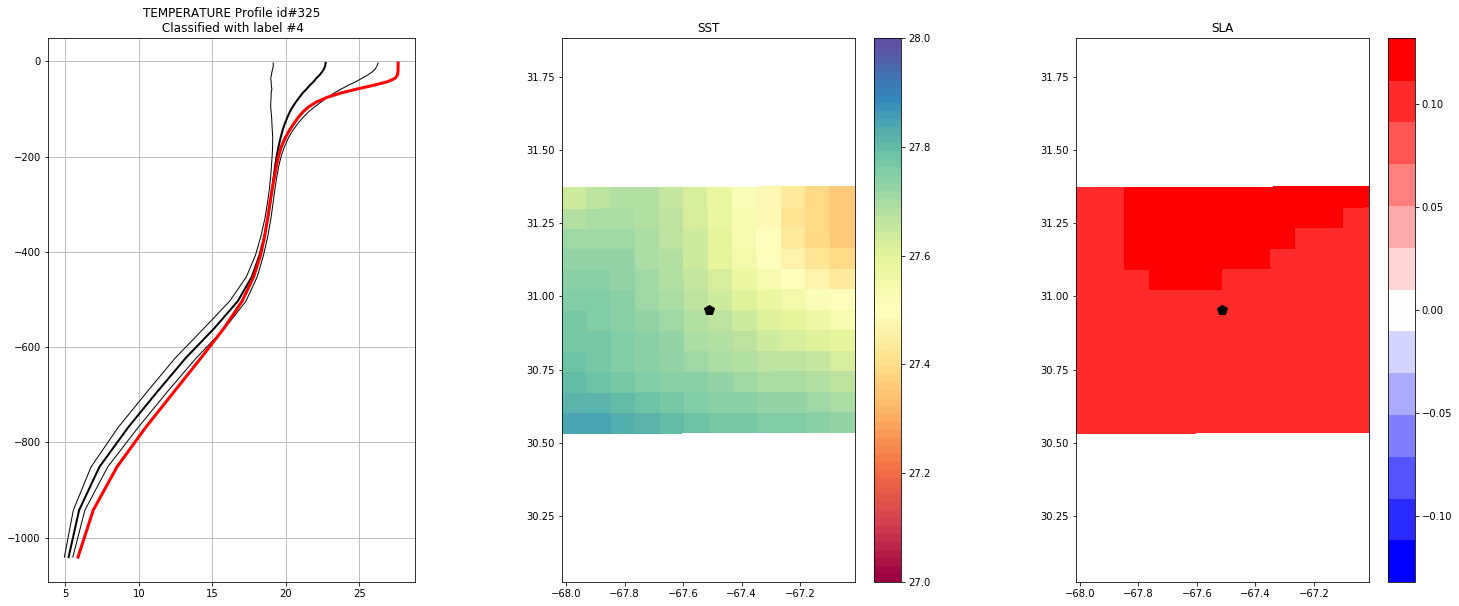

In [196]:
# Load Class mean and std profiles:
PCM = pd.read_csv('NATL12_GSbox_PCM_profils.csv',sep=';',header=0).to_xarray()
PCM['dpt'] = xr.DataArray(ds['dpt'].values, dims='index')
PCM = PCM.rename({"index": "depth"})

# Select the observation index to plot:
# i_obs = 0
i_obs = np.random.randint(0,ds['n_obs'].max()-1,1)[0] # Because n_obs is 1-based
obs_label = ds['LABEL'].isel(n_obs=i_obs)

# Plot it:
fig = plt.figure(figsize=(25, 10))
grid = plt.GridSpec(1, 3, wspace=0.4, hspace=0.3)

def show_loc():
    y = ds['lat'].isel(n_obs=i_obs).isel(latitude=patch_length_lat).isel(longitude=patch_length_lon)
    x = ds['lon'].isel(n_obs=i_obs).isel(latitude=patch_length_lat).isel(longitude=patch_length_lon)
    plt.plot(x, y, 'kp', markersize=10)

# Profile:
ax = plt.subplot(grid[0, 0])
plt.plot(PCM['MU'+str(int(obs_label))],ds['dpt'], color='k', linewidth=2)
plt.plot(PCM['MU'+str(int(obs_label))]-PCM['SI'+str(int(obs_label))],ds['dpt'], color='k', linewidth=1)
plt.plot(PCM['MU'+str(int(obs_label))]+PCM['SI'+str(int(obs_label))],ds['dpt'], color='k', linewidth=1)
plt.plot(ds['TEMP'].isel(n_obs=i_obs), ds['dpt'], color='r', linewidth=3)
ax.set_title( ("TEMPERATURE Profile id#%i\n Classified with label #%i")%(i_obs, ds['LABEL'].isel(n_obs=i_obs)) )
ax.grid('on')

# Sea Surface Temperature Map:
ax = plt.subplot(grid[0, 1])
K = 68
cmap = func.cmap_discretize(plt.cm.Spectral, K)
ext = np.round([ds['SST'].isel(n_obs=i_obs).min(), ds['SST'].isel(n_obs=i_obs).max()])
plt.pcolormesh(ds['lon'].isel(n_obs=i_obs), ds['lat'].isel(n_obs=i_obs), ds['SST'].isel(n_obs=i_obs), cmap=cmap, vmin=ext[0],vmax=ext[1])
show_loc()
ax.axis('equal')
plt.colorbar()
ax.set_title('SST')

# Sea Surface Height:
ax = plt.subplot(grid[0, 2])
K = 13
cmap = func.cmap_discretize(plt.cm.bwr, K)
ext = 1.1*np.round(np.max(np.abs([ds['SLA'].isel(n_obs=i_obs).min(), ds['SLA'].isel(n_obs=i_obs).max()])),2)
plt.pcolormesh(ds['lon'].isel(n_obs=i_obs), ds['lat'].isel(n_obs=i_obs), ds['SLA'].isel(n_obs=i_obs), cmap=cmap, vmin=-ext,vmax=ext)
show_loc()
ax.axis('equal')
plt.colorbar()
ax.set_title('SLA')

### STEP I : Initiate features X and target variable Y

Features X is (SLA, SST) flaten while target Y is the temperature


In [83]:
Y = temp
X = features

# I - Remove Nan Value
X = lib.replace_nan(X)
Y = lib.replace_nan(Y)

depth = Y.shape[1]
nb_features = X.shape[1]

X.shape= (706, 338)
Y.shape= (706, 36)


### STEP II : Preprocessing PCA

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)
Number of acp components features=  338
Number of acp components target=  36
cumsum variance explained=  [0.55578946 0.8259849  0.87634053 0.90647878 0.91517854 0.92386563
 0.93251621 0.94115026 0.94974838 0.95832979 0.96677064 0.97256196
 0.97831674 0.98402766 0.98856866 0.99238156 0.99453059 0.99607895
 0.99725307 0.99778305 0.99828695 0.99858563 0.99887673 0.9990362
 0.99917716 0.99929994 0.99941512 0.99950938 0.99957879]
cumsum variance explained target=  [0.83788849 0.95117536 0.98499285 0.99388352 0.99751603]


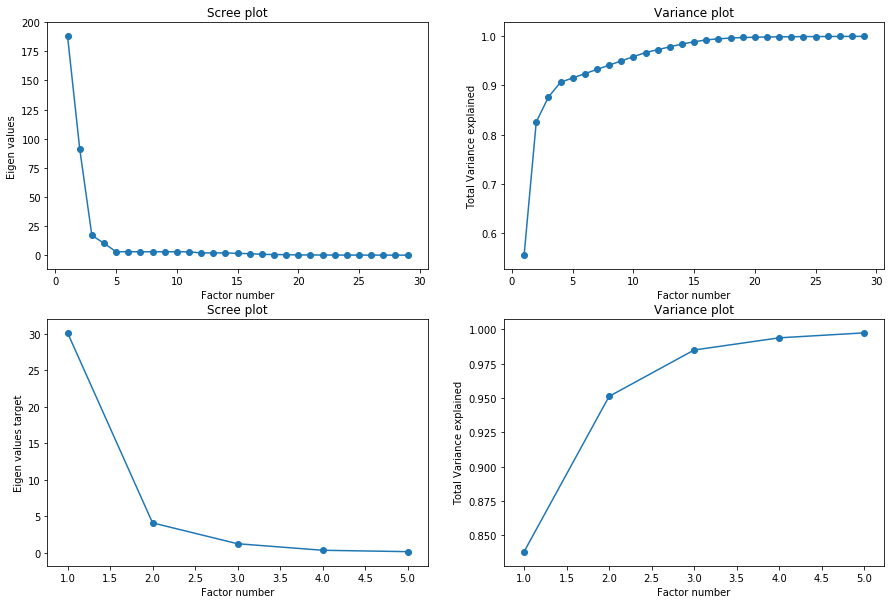

In [198]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from multiprocessing import Pool
import time
from tqdm import *

cumsum_var_explained, cumsum_var_explained_target = lib.double_acp_target_feature(X,Y,to_plot=True,nb_factor_max =30,nb_factor_max_target = 6)

### STEP III : Compute the Bayesian Information Criterion on PCA projected data 

In statistics, the Bayesian information criterion (BIC) is a criterion for model selection among a finite set of models; the model with the lowest BIC is preferred. It is based on the likelihood function and on the number of parameters of the model involved.

When fitting models, it is possible to increase the likelihood by adding parameters, but doing so may result in overfitting. BIC  attempts to resolve this problem by introducing a penalty term for the number of parameters in the model; the penalty term is larger in BIC.

In our case, the Bayesian Information Criterion (BIC) is calculted given the following formula :

<img src="https://latex.codecogs.com/svg.latex?\Large&space;BIC=-2*log(lik)+n_{params}*log(size_{samples})" title="BIC" />



### Experiment I : Computing the BIC

- 2-7 classes
- 30 iterations of randomized initialization EM
- 30 iterations for each EM algorithm

To effectively run the experiment toggle the boolean : Execute_experiment

In [199]:
Execute_experiment = False

# % of variance to keep for the PCA 

var_feature = 0.99
var_target = 0.99

def imap_unordered_bar(func, args, n_processes = 16):
    """
    Function to have a tqdm style progress bar on parallel processes, works as pmap
    """
    p = Pool(n_processes)
    res_list = []
    with tqdm(total = len(args)) as pbar:
        for i, res in tqdm(enumerate(p.imap_unordered(func, args))):
            pbar.update()
            res_list.append(res)
    pbar.close()
    p.close()
    p.join()
    return res_list

if Execute_experiment:
    BIC={}
    nb_class=[2,3,4,5,6,7]
    len_class =len(nb_class)
    var_feature = 0.99
    var_target = 0.99

    inputs=[]
    iter_EM=30
    method ="random"
    nb_iter_per_parameters = 30
    for i in range(len_class):
        for j in range(nb_iter_per_parameters):
            clust =np.array([np.random.randint(0,nb_class[i]) for l in range(size(Y,0))])
            inputs.append([X,Y,nb_class[i],method,iter_EM,cumsum_var_explained_target,cumsum_var_explained,var_feature,var_target,clust])
    BICs_ = imap_unordered_bar(lib.BIC_calculation, inputs)

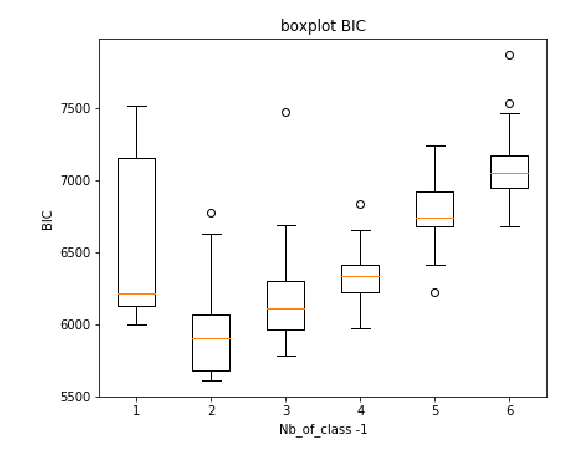

In [200]:
if Execute_experiment:
    pylab.rcParams['figure.figsize']=(8,6)
    l1 = len(nb_class)
    array_struct = zeros((l1,nb_iter_per_parameters))
    parameters_struct_ = zeros((l1,nb_iter_per_parameters))

    for i in range(l1):
        for p in range(nb_iter_per_parameters):
            array_struct[i,p]=BICs_[i*nb_iter_per_parameters+p][0]
            parameters_struct_[i,p]=BICs_[i*nb_iter_per_parameters+p][1]

    fig = plt.figure(figsize=(5,4))
    ax = fig.add_axes([1,1,1,1])
    plt.boxplot(array_struct.T)
    plt.title("boxplot BIC")
    xlabel("Nb_of_class -1")
    ylabel("BIC")
    plt.savefig("figure/boxplotBIC_2_to_7_classes.png",bbox_inches='tight')
else:
    plt.rcParams.update({'figure.figsize': (10,8)})
    image = plt.imread("figure/boxplotBIC_2_to_7_classes.png")
    plt.axis("off")
    plt.imshow(image)

### Experiment II : Combining multiple EM algorithm

- Generate many EM and store pi_hats (probability of belonging to a class)
- Re-label to minimize a given distance
- The maximum occuring label is chosen as the most likely class

In [202]:
## Compute the nb_iter_per_parameters initialisation of EM algorithm
Execute_experiment = False
nb_iter_per_parameters = 150

if Execute_experiment :
    inputs   = []
    nb_class = 4
    iter_EM  = 30
    method   ="random"
    nb_iter_per_parameters = 150

    # Transformation – Standard Scaling of the features & target
    sc_features = StandardScaler()
    sc_target   = StandardScaler()
    
    X  = sc_features.fit_transform(X)
    Y = sc_target.fit_transform(Y)
    
    nb_component_target = np.where(cumsum_var_explained_target>var_target)[0][0]
    nb_component_features = np.where(cumsum_var_explained>var_feature)[0][0]
    acp_features = PCA(svd_solver='full',n_components =nb_component_features+1)
    acp_target = PCA(svd_solver='full',n_components =nb_component_target+1)
    X_orth = acp_features.fit_transform(X)
    Y_orth = acp_target.fit_transform(Y)
    for j in range(nb_iter_per_parameters):
        clust=np.array([np.random.randint(0,nb_class) for i in range(size(Y,0))])
        inputs.append([X_orth,Y_orth,nb_class,method,iter_EM,clust])
        
    # Parallelize the execution of the EM algorithm (random init)
    pi_hats_ = imap_unordered_bar(lib.EM_with_init, inputs)

**Hard encoding results keeping the maximum likelihood**

In [201]:
from sklearn.utils import linear_assignment_ as la
def geo_error(lat_lng,index_ref,new_index,nb_class):
    """
    Define the geographical error of assignment using chamfer distance.
    """
    return(array([[chamfer_distance(lat_lng[np.where(index_ref==i),:].squeeze(),lat_lng[np.where(new_index==j),:].squeeze()) for i in range(nb_class)] for j in range(nb_class)]))

def chamfer_distance(X,Y):
    """
    Distance used in pattern recognition : looks for similar shape between the clouds.
    """
    sum_x = 0
    for i in range(len(X)):
        sum_x += min([np.linalg.norm(X[i]-Y[k]) for k in range(len(Y))])
    sum_y = 0
    for i in range(len(Y)):
        sum_x += min([np.linalg.norm(Y[i]-X[k]) for k in range(len(X))])
    return(sum_x+sum_y)

lat_lng = zeros((len(lat),2))
lat_lng[:,0]=lat
lat_lng[:,1]=long

# We take G.Maze labels as "ground_truth": gt_label
gt_label = ndarray.astype(label.squeeze()-1,int)

**We observe how the best simulation is qualitatively performing**

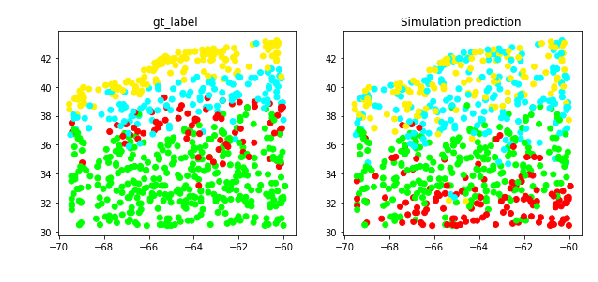

In [205]:
Execute_experiment=False
if Execute_experiment :
    likelihood_ = np.array([pi_hats_[k][1][-1] for k in range(nb_iter_per_parameters)])
    best_candidate= np.argmax(likelihood_)
    pi_hat_best = pi_hats_[best_candidate][0]

    hard_best = ndarray.astype(np.argmax(pi_hat_best,1),int)
    gt_label = ndarray.astype(label.squeeze()-1,int)

    geo_distance = geo_error(lat_lng,gt_label,hard_best,nb_class)
    assignment_matrix  = la.linear_assignment(geo_distance) # distance_matrix)

    hard_best_ = zeros(len(hard_best))
    for k in range(nb_class):
        hard_best_[np.where(hard_best==k)]= assignment_matrix[k][1]
    hard_best_=ndarray.astype(hard_best_,int)
    from sklearn.metrics import confusion_matrix
    y_true = gt_label
    y_pred = hard_best_
    conf_mat = confusion_matrix(y_true, y_pred)

    norm_confusion_mat = array([conf_mat[k] / sum(conf_mat[k]) for k in range(len(conf_mat))])
    print("confusion_matrice = ")
    print(norm_confusion_mat)

    accurate_assignment= len(find([y_true[k]==y_pred[k] for k in range(len(y_true))]))
    accuracy = accurate_assignment/len(y_true)
    print("accuracy=",accuracy)
    print("color=Red yellow, turquoise green")
    
    color=["#FF0000","#FFF000","#00FFFF","#00FF00"]
    real_color = [color[gt_label[k]] for k in range(len(hard_best))]
    color_stat = [color[hard_best_[k]] for k in range(len(hard_best))]
    figure,ax = subplots(figsize=(10,4))
    subplot(121)
    scatter(long,lat,color=real_color)
    title("gt_label ")
    subplot(122)
    scatter(long,lat,color=color_stat)
    title("Simulation prediction ")
else:
    plt.rcParams.update({'figure.figsize': (10,8)})
    image = plt.imread("figure/label_best_pred.png")
    plt.axis("off")
    plt.imshow(image)

### Combination of the different EM simulation :

In [49]:
## Combine the outputs
Execute_experiment=False

if Execute_experiment :

    # index_class is the first simulation output, we choose one class per sample (most likely)
    index_class = gt_label
    
    for k in range(nb_class):
        ind_class_k = np.where(index_class==k)
        weight= pi_hats_[0][0][ind_class_k,k].squeeze()
        vector_temp =Y_orth[ind_class_k,:].squeeze()
        
    # big_matrix is the matrix in which we store re-labeled classes
    big_matrix = zeros((len(index_class),len(pi_hats_)))   
        
    for j in tqdm(range(0,len(pi_hats_))):
        new_index_class = np.argmax(pi_hats_[j][0],1)
        
        for k in range(nb_class):
            weight= pi_hats_[j][0][new_index_class,k].squeeze()
            vector_temp =Y_orth[new_index_class,:].squeeze()
        ground_truth_label = index_class
        estimated_label    = new_index_class
        
        geo_distance = geo_error(lat_lng,index_class,new_index_class,nb_class)
        assignment_matrix  = la.linear_assignment(geo_distance)#

        new_index_class_ = zeros(len(new_index_class))
        for k in range(nb_class):
            new_index_class_[np.where(new_index_class==k)]= assignment_matrix[k][1]
        big_matrix[:,j] = new_index_class_

    big_matrix=ndarray.astype(big_matrix,int)
    
    # We take the most likely class according to the simulations
    statistical_class = [np.bincount(big_matrix[k,:]).argmax() for k in range(big_matrix.shape[0])]

100%|██████████| 150/150 [13:31<00:00,  5.25s/it]


### Assert how well it combines : 

In [208]:
simu=1

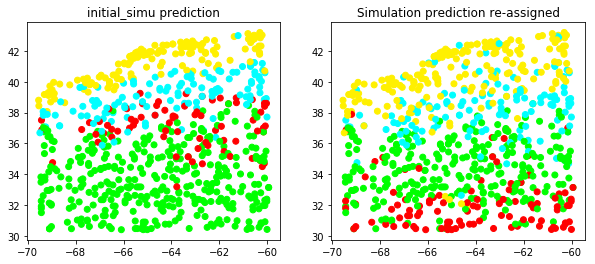

In [209]:
# Run several time this cell to see one EM algorithm output
if Execute_experiment :
    simu +=1
    real_color = [color[gt_label[k]] for k in range(len(statistical_class))]
    color_stat = [color[big_matrix[k,simu]] for k in range(len(statistical_class))]
    figure,ax = subplots(figsize=(10,4))
    subplot(121)
    scatter(long,lat,color=real_color)
    title("initial_simu prediction")
    subplot(122)
    scatter(long,lat,color=color_stat)
    title("Simulation prediction re-assigned")

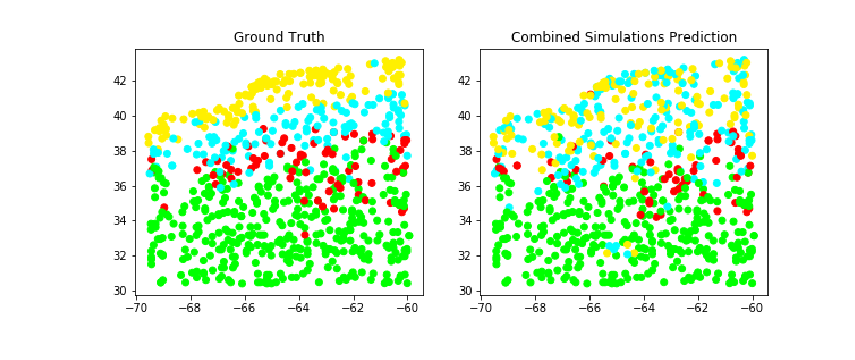

In [210]:
# We have combined the differents simulation, now we assign the label with those of the ground_truth so we can compare
save_res = False
Execute_experiment= False
if Execute_experiment :
    color=["#FF0000","#FFF000","#00FFFF","#00FF00"]
    color_stat = [color[statistical_class[k]] for k in range(len(statistical_class))]
    gt_label   = ndarray.astype(label-1,int).squeeze()
    real_color =  [color[gt_label[k]] for k in range(len(gt_label))]
    
    # Assignment between stat and ground truth
    ground_truth_rpz_class= zeros((nb_class,Y_orth.shape[1]))
    rpz_stat_class = zeros((nb_class,Y_orth.shape[1])) 

    for k in range(nb_class):
        ground_truth_rpz_class[k,:] = np.mean(Y_orth[np.where(gt_label==k),:].squeeze(),0)
        rpz_stat_class[k,:] = np.mean(Y_orth[np.where(np.array(statistical_class)==k),:].squeeze(),0)

    distance_matrix    = array([[np.linalg.norm(ground_truth_rpz_class[i,:]-rpz_stat_class[j,:]) for i in range(nb_class)] for j in range(nb_class)])                      
    assignment_matrix = la.linear_assignment(distance_matrix)
    print(assignment_matrix)
    new_stat_class = zeros(len(statistical_class))
    for k in range(nb_class):
        new_stat_class[np.where(np.array(statistical_class)==k)]= assignment_matrix[k][1]
        
    new_stat_class=ndarray.astype(new_stat_class,int)
    color_stat = [color[new_stat_class[k]] for k in range(len(statistical_class))]
    figure,ax = subplots(figsize=(10,4))
    subplot(121)
    scatter(long,lat,color=real_color)
    title("Ground Truth")
    subplot(122)
    scatter(long,lat,color=color_stat)
    title("Combined Simulations Prediction")
    if save_res:
        savefig("figure/4classes_assignment.png")
else:
    plt.rcParams.update({'figure.figsize': (15,6)})
    plt.axis("off")
    img= mpimg.imread("figure/4classes_assignment.png")
    plt.imshow(img)
    

**Here we print some metrics : confusion matrix, accuracy**

In [214]:
print(Execute_experiment)
if Execute_experiment:
    from sklearn.metrics import confusion_matrix
    y_true = gt_label
    y_pred = new_stat_class
    conf_mat = confusion_matrix(y_true, y_pred)

    norm_confusion_mat = array([conf_mat[k] / sum(conf_mat[k]) for k in range(len(conf_mat))])
    print("confusion_matrix = ")
    print(norm_confusion_mat)

    accurate_assignment= len(find([y_true[k]==y_pred[k] for k in range(len(y_true))]))
    accuracy = accurate_assignment/len(y_true)
    print("accuracy=",accuracy)
    print("color=Red yellow, turquoise green")
else:
    print("""[[0.1369863  0.         0.79452055 0.06849315]
 [0.         0.4893617  0.5106383  0.        ]
 [0.         0.40983607 0.59016393 0.        ]
 [0.03783784 0.0027027  0.01081081 0.94864865]]
accuracy= 0.7110481586402266
color=Red yellow, turquoise green""")


False
[[0.1369863  0.         0.79452055 0.06849315]
 [0.         0.4893617  0.5106383  0.        ]
 [0.         0.40983607 0.59016393 0.        ]
 [0.03783784 0.0027027  0.01081081 0.94864865]]
accuracy= 0.7110481586402266
color=Red yellow, turquoise green


In [56]:
# We redefine init_EM function to initialize its EM with labels pre determined combining several runs
def init_EM_latent_class_regression(X,Y,K,method,clust1=[0]):   
    # size
    n=size(Y,0)
    nb_features = X.shape[1]
    depth = Y.shape[1]
    
    # clustering method
    if method == "kmeans":
        clust = KMeans(n_clusters=K, random_state=0).fit_predict(hstack((X[:,1:X.shape[1]],Y))) # see why its better than hstack((X[:,1:X.shape[1]],Y))
        #hstack((array([X[:,1]]).T,Y))
    elif method == "random":
        if len(clust1)>1:
            clust=clust1
        else:
            clust=np.array([np.random.randint(0,K) for i in range(n)]);
    elif method=="init_weight":
        clust=clust1
    # initialize lambda
    hist_k = plt.hist(clust,K,density=True);
    plt.close()
    width_bins = hist_k[1][1] -hist_k[1][0] 
    nb_k = hist_k[0]*width_bins * len(X)

    lambda_init=zeros(K)
    for k in range(K):
        lambda_init[k]=nb_k[k]/n

    Beta_init  =array(zeros((K,nb_features,depth)))
    Sigma_init =array(zeros((K,depth,depth)))

    # initialize Beta and Sigma
    for k in range(0,K): 
        Beta_init[k,:,:] = np.linalg.lstsq(X[np.where(clust==k)[0],:],Y[np.where(clust==k)[0],:])[0]
        Sigma_init[k,:,:] = cov((Y[np.where(clust==k)[0],:]-X[np.where(clust==k)[0],:]@(Beta_init[k,:,:].reshape((nb_features,depth)))).T)

    return(lambda_init,Beta_init,Sigma_init)

**Here we run a last EM initialized with the combination of output we obtained before**

Beta and Sigma are saved after this run to make prediction in the future.

[[0 0]
 [1 1]
 [2 2]
 [3 3]]


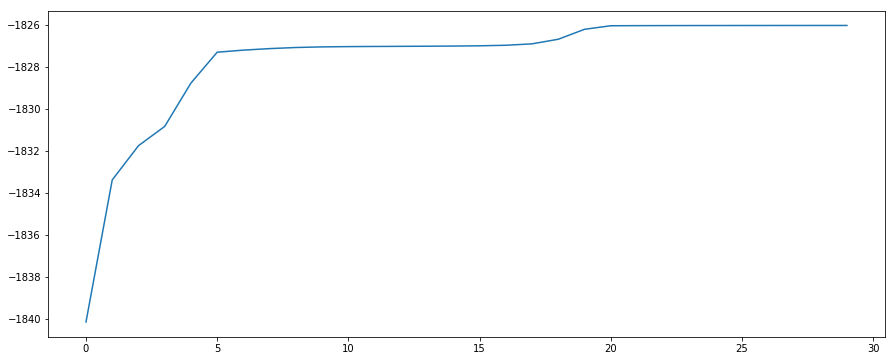

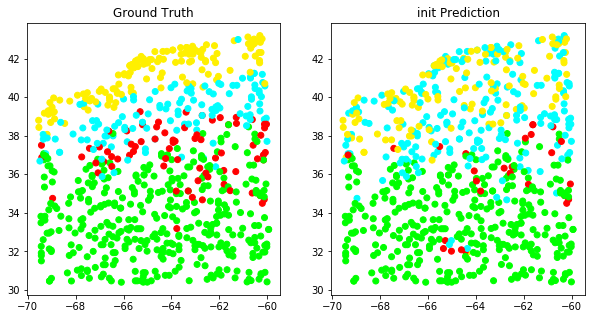

In [57]:
# Generate the pseudo repartition as an init
save_res=False
Execute_experiment=False
if Execute_experiment :
    K = 4
    iter_EM=30
    method ="init_weight"
    lambda_init,Beta_init,Sigma_init = init_EM_latent_class_regression(X_orth,Y_orth,K,method,y_pred)
    log_lik,lambda_hat,Beta_hat,Sigma_hat,Y_hat,pi_hat,Z_hat=lib.EM_latent_class_regression(X_orth,Y_orth,lambda_init,Beta_init,Sigma_init,iter_EM)
    kmeans_index_class =ndarray.astype(np.argmax(pi_hat,1),int)
    rpz_kmeans_class = zeros((nb_class,Y_orth.shape[1]))
    ground_truth_rpz_class= zeros((nb_class,Y_orth.shape[1]))
    for k in range(nb_class):
        ground_truth_rpz_class[k,:] = np.mean(Y_orth[np.where(gt_label==k),:].squeeze(),0)
        rpz_kmeans_class[k,:] = np.mean(Y_orth[np.where(np.array(kmeans_index_class)==k),:].squeeze(),0)

    # Assignment between kmeans and ground truth
    distance_matrix    = array([[np.linalg.norm(ground_truth_rpz_class[i,:]-rpz_kmeans_class[j,:]) for i in range(nb_class)] for j in range(nb_class)])                      
    assignment_matrix = la.linear_assignment(distance_matrix)
    new_kmeans_class = zeros(len(kmeans_index_class))
    for k in range(nb_class):
        new_kmeans_class[np.where(np.array(kmeans_index_class)==k)]= assignment_matrix[k][1]

    new_kmeans_class = ndarray.astype(new_kmeans_class,int)
    color_kmeans = [color[new_kmeans_class[k]] for k in range(len(new_kmeans_class))]
    plot(log_lik)
    print(assignment_matrix)  
    figure,ax = subplots(figsize=(10,5))
    subplot(121)
    scatter(long,lat,color=real_color)
    title("Ground Truth")
    subplot(122)
    scatter(long,lat,color=color_kmeans)
    title("init Prediction")
    if save_res:
        savefig("figure/4classes_assignment_kmeans.png")
else:
    plt.rcParams.update({'figure.figsize': (15,6)})
    plt.axis("off")
    img= mpimg.imread("figure/4classes_assignment_kmeans.png")
    plt.imshow(img)

In [216]:
# Compare results : 
if Execute_experiment :
    from sklearn.metrics import confusion_matrix
    y_true = gt_label
    y_pred = new_kmeans_class
    conf_mat = confusion_matrix(y_true, y_pred)

    norm_confusion_mat = array([conf_mat[k] / sum(conf_mat[k]) for k in range(len(conf_mat))])
    print("confusion_matrice = ")
    print(norm_confusion_mat)

    accurate_assignment= len(find([y_true[k]==y_pred[k] for k in range(len(y_true))]))
    accuracy = accurate_assignment/len(y_true)
    print("accuracy=",accuracy)
    print("color=Red yellow, turquoise green")
    
else:
    print("""
confusion_matrice = 
[[0.1369863  0.01369863 0.79452055 0.05479452]
 [0.         0.4893617  0.5106383  0.        ]
 [0.         0.45081967 0.54918033 0.        ]
 [0.04594595 0.0027027  0.02162162 0.92972973]]
accuracy= 0.6940509915014165
color=Red yellow, turquoise green""")


confusion_matrice = 
[[0.1369863  0.01369863 0.79452055 0.05479452]
 [0.         0.4893617  0.5106383  0.        ]
 [0.         0.45081967 0.54918033 0.        ]
 [0.04594595 0.0027027  0.02162162 0.92972973]]
accuracy= 0.6940509915014165
color=Red yellow, turquoise green


In [217]:
# Save parameters 
save_res = False
if save_res :
    f = open('store1.pckl', 'wb')
    pickle.dump([log_lik,lambda_hat,Beta_hat,Sigma_hat,Y_hat,pi_hat,Z_hat], f)
    f.close()

**Experiment III : Observe clusterization with a simple k-means**

[[0 3]
 [1 2]
 [2 1]
 [3 0]]


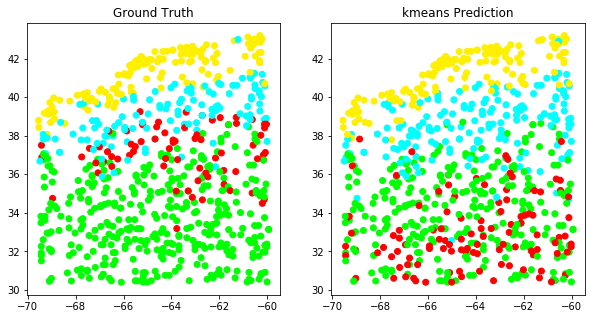

In [61]:
save_res=False
if Execute_experiment :
    K= 4
    iter_EM=30
    method ="kmeans"
    lambda_init,Beta_init,Sigma_init = lib.init_EM_latent_class_regression(X_orth,Y_orth,K,method)
    log_lik,lambda_hat,Beta_hat,Sigma_hat,Y_hat,pi_hat,Z_hat=lib.EM_latent_class_regression(X_orth,Y_orth,lambda_init,Beta_init,Sigma_init,iter_EM)
    kmeans_index_class =ndarray.astype(np.argmax(pi_hat,1),int)
    rpz_kmeans_class = zeros((nb_class,Y_orth.shape[1]))
    ground_truth_rpz_class= zeros((nb_class,Y_orth.shape[1]))
    for k in range(nb_class):
        ground_truth_rpz_class[k,:] = np.mean(Y_orth[np.where(gt_label==k),:].squeeze(),0)
        rpz_kmeans_class[k,:] = np.mean(Y_orth[np.where(np.array(kmeans_index_class)==k),:].squeeze(),0)

    # Assignment between kmeans and ground truth
    distance_matrix    = array([[np.linalg.norm(ground_truth_rpz_class[i,:]-rpz_kmeans_class[j,:]) for i in range(nb_class)] for j in range(nb_class)])                      
    assignment_matrix = la.linear_assignment(distance_matrix)
    new_kmeans_class = zeros(len(kmeans_index_class))
    for k in range(nb_class):
        new_kmeans_class[np.where(np.array(kmeans_index_class)==k)]= assignment_matrix[k][1]

    new_kmeans_class = ndarray.astype(new_kmeans_class,int)
    color_kmeans = [color[new_kmeans_class[k]] for k in range(len(new_kmeans_class))]
    
    print(assignment_matrix)  
    figure,ax = subplots(figsize=(10,5))
    subplot(121)
    scatter(long,lat,color=real_color)
    title("Ground Truth")
    subplot(122)
    scatter(long,lat,color=color_kmeans)
    title("kmeans Prediction")
    if save_res:
        savefig("figure/4classes_assignment_kmeans.png")
else:
    plt.rcParams.update({'figure.figsize': (15,6)})
    plt.axis("off")
    img= mpimg.imread("figure/4classes_assignment_kmeans.png")
    plt.imshow(img)

In [218]:
Execute_experiment=False

In [63]:
if Execute_experiment:
    from sklearn.metrics import confusion_matrix
    y_true = gt_label
    y_pred = new_kmeans_class
    conf_mat = confusion_matrix(y_true, y_pred)

    norm_confusion_mat = array([conf_mat[k] / sum(conf_mat[k]) for k in range(len(conf_mat))])
    print("confusion_matrice = ")
    print(norm_confusion_mat)

    accurate_assignment= len(find([y_true[k]==y_pred[k] for k in range(len(y_true))]))
    accuracy = accurate_assignment/len(y_true)
    print("accuracy=",accuracy)
    print("color=Red yellow, turquoise green")
else:
    print("confusion_matrice =  \n[[0.17808219 0.         0.7260274  0.09589041]\n[0.         0.95035461 0.04964539 0.        ] \n[0.         0.09836066 0.89344262 0.00819672] \n[0.71621622 0.         0.00540541 0.27837838]]\naccuracy= 0.5084985835694051\ncolor=Red yellow, turquoise green")

confusion_matrice =  
[[0.17808219 0.         0.7260274  0.09589041]
[0.         0.95035461 0.04964539 0.        ] 
[0.         0.09836066 0.89344262 0.00819672] 
[0.71621622 0.         0.00540541 0.27837838]]
accuracy= 0.5084985835694051
color=Red yellow, turquoise green


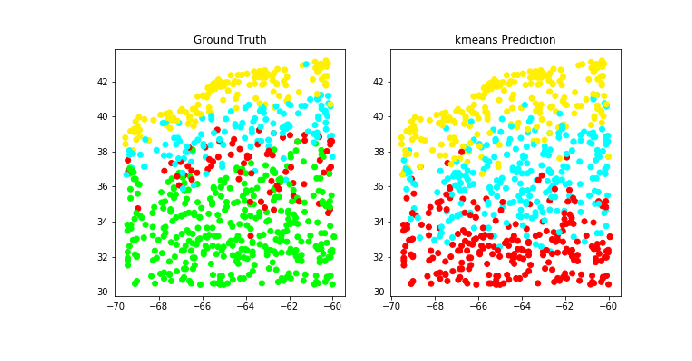

In [64]:
if Execute_experiment:
    K= 3
    iter_EM=30
    method ="kmeans"
    lambda_init,Beta_init,Sigma_init = lib.init_EM_latent_class_regression(X_orth,Y_orth,K,method)
    log_lik,lambda_hat,Beta_hat,Sigma_hat,Y_hat,pi_hat,Z_hat=lib.EM_latent_class_regression(X_orth,Y_orth,lambda_init,Beta_init,Sigma_init,iter_EM)
    kmeans_index_class =np.argmax(pi_hat,1)
    rpz_kmeans_class = zeros((nb_class,Y_orth.shape[1]))
    color_kmeans = [color[kmeans_index_class[k]] for k in range(len(new_kmeans_class))]
    
    figure,ax = subplots(figsize=(10,5))
    subplot(121)
    scatter(long,lat,color=real_color)
    title("Ground Truth")
    subplot(122)
    scatter(long,lat,color=color_kmeans)
    title("kmeans Prediction")
    savefig("figure/3_classes_assignment_kmeans.png")
else:
    plt.rcParams.update({'figure.figsize': (15,6)})
    plt.axis("off")
    img= mpimg.imread("figure/3_classes_assignment_kmeans.png")
    plt.imshow(img)

# Temperature profile estimation from surfacic data : RMS-Heatmap 

Steps followed in this section : 

- Re-Load stored data.
- Compute a first prediction with label as knowledge to set infimum of the error.
- Use Cartopy as visualization tool to plot 2D heatmap of RMS.
     First plot a scatter, then a NN filtered version of RMS
- Complete the study with a full prediction : label unknown.



In [69]:
def temperature_profile(X_orth,Beta_hat,label):
    """
    return the targeted temperature profile using features and linear coefficients 
    with : X_orth surface observation
           Beta_hat : Regression coefficient
           label:  label of the sample observed
    """
    output = np.array([X_orth[l,:]@Beta_hat[label[l],:,:] for l in range(len(label))])
    return(output)

In [74]:
# Here we load the stored data
import pickle
f = open('store.pckl', 'rb')
[log_lik,lambda_hat,Beta_hat,Sigma_hat,Y_hat,pi_hat,Z_hat] = pickle.load(f)
f.close()

# From pi_hat we hardcode the label 
label_pred = ndarray.astype(np.argmax(pi_hat,1),int)

As we run from load data, we need to recompute the ACP (we didn't store the coefficient)


In [84]:
# Transformation – Standard Scaling of the features & target
sc_features = StandardScaler()
sc_target   = StandardScaler()

Y = temp
X = features
X = lib.replace_nan(X)
Y = lib.replace_nan(Y)

X  = sc_features.fit_transform(X)
Y  = sc_target.fit_transform(Y)

nb_component_target = np.where(cumsum_var_explained_target>var_target)[0][0]
nb_component_features = np.where(cumsum_var_explained>var_feature)[0][0]
acp_features = PCA(svd_solver='full',n_components =nb_component_features+1)
acp_target = PCA(svd_solver='full',n_components =nb_component_target+1)
X_orth = acp_features.fit_transform(X)
Y_orth = acp_target.fit_transform(Y)

**Temperature prediction process :**

- Predict the temperature in the ACP space
- Inverse transform the prediction
- Rescale it to temperature profile in °C
- Use RMS as error metric


In [85]:
# We estimate the temperature from surfacic info
temp_pred = temperature_profile(X_orth,Beta_hat,label_pred)

# ACP inverse
temp_true_profile = acp_target.inverse_transform(temp_pred) 

# Rescaling
rescale_temp =sc_target.inverse_transform(temp_true_profile) 

# Compute the error RMS
RMS_plan = sqrt(mean((rescale_temp - temp)**2,1))

Some statistics about the prediction:

mean(RMSE) = 0.85°C
min(RMSE) =  0.12°C
max(RMSE) = 3.64°C


{'whiskers': [<matplotlib.lines.Line2D at 0x7fd352708780>,
 'caps': [<matplotlib.lines.Line2D at 0x7fd352708e10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fd352708630>],
 'medians': [<matplotlib.lines.Line2D at 0x7fd3527154e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fd352715828>],
 'means': []}

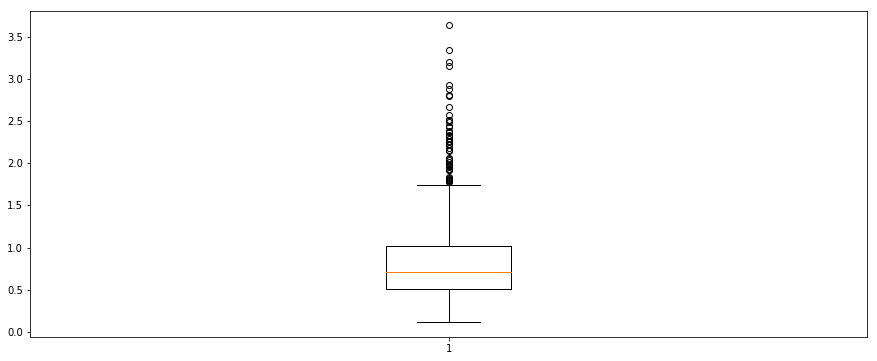

In [181]:
print("mean(RMSE) = "+str(round(mean(RMS_plan),2)) +"°C")
print("min(RMSE) =  "+str(round(min(RMS_plan),2)) +"°C")
print("max(RMSE) = "+str(round(max(RMS_plan),2)) +"°C")

boxplot(RMS_plan)

# Using cartopy for visualization

A tutorial can be found at :
https://ipython-books.github.io/146-manipulating-geospatial-data-with-cartopy/

To install it one may run : !conda install -c conda-forge cartopy --yes


As our patches are not on a regular grid we offer different ways of visualizing the errors : 
- With a simple scatter
- With a grid interpolated linearly ( the results are not very good)
- with a Nearest neighbor filtered grid

In [150]:
# Import everything to run cartopy 
import io
import requests
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as col
from matplotlib.colors import Normalize
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
import cartopy.io.shapereader as shpreader
import os
import matplotlib.pyplot as plt
from netCDF4 import Dataset as netcdf_dataset
import numpy as np
from cartopy import config
import cartopy.crs as ccrs

# Load the patches 
fname = os.path.join('ALLPATCHES_NX13_NY13_bis.nc')
dataset = netcdf_dataset(fname)
sst = dataset.variables['SST'][:, 7, 7]
lats = dataset.variables['lat'][:,7,7]
lons = dataset.variables['lon'][:,7,7]


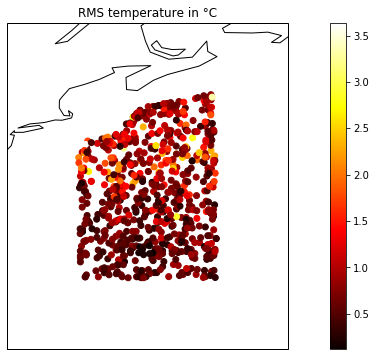

In [151]:
# first interpolation way 
# from scipy import interpolate
# f = interpolate.interp2d(lons,lats, RMS_plan, kind='linear')
# xnew = np.arange(min(lons), max(lons),1)
# ynew = np.arange(min(lats),max(lats), 1)
# znew = f(xnew, ynew)

ax = plt.axes(projection=ccrs.PlateCarree())

# if interpolation is used : 
# CS3 = plt.contourf(xnew, ynew, znew, 60,
#            transform=ccrs.PlateCarree(),cmap=plt.cm.hot)

CS3 =ax.scatter(lons,lats,c=RMS_plan,transform=ccrs.PlateCarree(),cmap=plt.cm.hot)
ax.set_extent([-5+min(lons), 5+max(lons), -5+min(lats),5+max(lats)])
ax.coastlines()
title("RMS temperature in °C")
plt.colorbar(CS3)
plt.show()

In [152]:
# Define function to smooth the heatmap
def norm_2(x,y):
    """
    Compute the norm L2 : ||x-y||2
    """
    dim = len(x)
    norm = 0
    for j in range(dim):
        norm+= (x[j]-y[j])**2
    return(sqrt(norm))

def nearest_neighbors(duet, lng_lat, z_value, n_neighbors):
    """
    Aim to guess the value of Z given a duet = (x,y) using the neighbors of duet and their known z_value
    
    Input : 
        - duet    : position we want to estimate z_values with n_neighbors
        - lng_lat : couple of latitude, longitude value for which z is known
        - z_value : value we want to estimate for a given duet
        - n_neighbors : number of neighbors we want to use for the estimation
    
    """
    len_lons= len(lons)
    
    # Store the distance to later extract the nearest neighbors
    distance = []
    for p in range(len_lons):
        distance.append(norm_2(duet,lng_lat[p,:]))
    
    # Select the nearest neighbors using distance list
    index_of_interest=[]
    for ind in range(n_neighbors):
        index_min = np.argmin(distance)
        index_of_interest.append(index_min)
        if ind==0:
            dist_ =distance.pop(index_min)
            
    # Compute the mean of the neighbors z_value
    mean_value=0
    for ind in range(n_neighbors):
        mean_value += z_value[index_of_interest[ind]]
    mean_value=mean_value/n_neighbors
    
    # Return the estimated z_value and the distance to the closest neighbor used  (useful later)
    return(mean_value,dist_)
        

**Smoothes the heatmap with a KNN approach**

In [153]:
# Define the number of neighbors
n_neighbors=50

# Data manipulation to create a structure of type (longitude,latitude)
lons = lons.reshape(-1,1)
lats =lats.reshape(-1,1)
lng_lat = np.concatenate((lons, lats), axis=1)

x = np.arange(min(lons),max(lons), 0.5)
y = np.arange(min(lats),max(lats), 0.5)
xx, yy = np.meshgrid(x, y, sparse=True)
z = np.zeros((yy.shape[0],xx.shape[1]))
for j in tqdm(range(yy.shape[0])):
    for l in range(xx.shape[1]):
        duet =(xx[0,l],yy[j,0])
        mean_value,dist_=nearest_neighbors(duet,lng_lat,RMS_plan,n_neighbors)
        if dist_>0.5:
            z[j,l] =0
        else:
            z[j,l] =mean_value

100%|██████████| 26/26 [00:11<00:00,  2.21it/s]


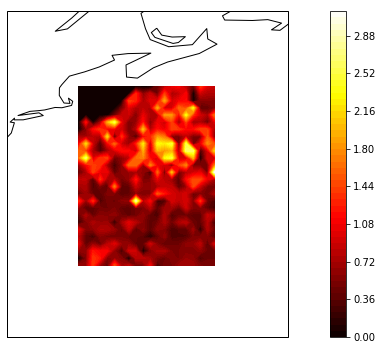

In [154]:
from scipy import interpolate
ax1 = plt.axes(projection=ccrs.PlateCarree())
CS3 = plt.contourf(xx[0,:], yy[:,0], z, 60,
            transform=ccrs.PlateCarree(),cmap=plt.cm.hot)
ax1.set_extent([-5+min(lons), 5+max(lons), -5+min(lats),5+max(lats)])
ax1.coastlines()
plt.colorbar(CS3)
plt.show()

**Probability density estimation of the Gaussian mixture**

This will help estimate the latent mode given surfacic data.

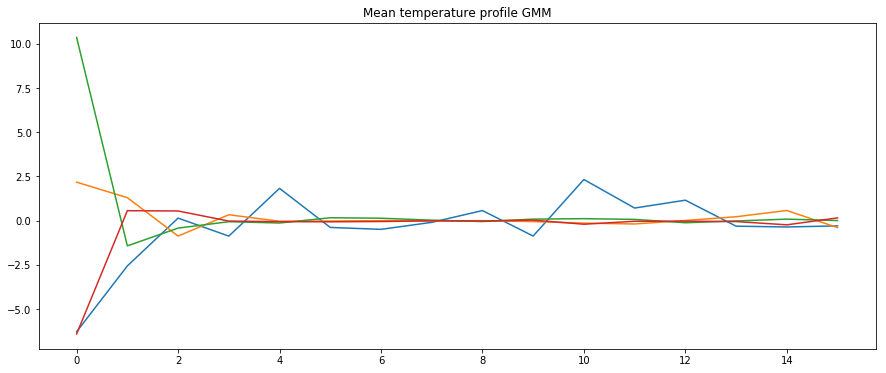

In [220]:
probability_density = zeros((len(X_orth),4))
for label in range(4):   
    ind_label = find(label_pred==label)
    mean_ = mean(X_orth[ind_label,:],0)
    cov_  = cov(X_orth[ind_label,:].T)
    plt.plot(mean_)
    for k in range(len(X_orth)):
        probability_density[k,label]= multivariate_normal.pdf(X_orth[k,:], mean=mean_, cov=cov_)
    title('Mean temperature profile GMM')

**Attributing label with max pdf:**

In [156]:
label_attributed = np.argmax(probability_density,1)

In [157]:
ratio_good_assignment= len(find(label_attributed==label_pred))/len(label_attributed)
print(ratio_good_assignment)

0.7294617563739377


In [158]:
temp_pred_lab = temperature_profile(X_orth,Beta_hat,label_attributed)

# ACP inverse
temp_true_profile = acp_target.inverse_transform(temp_pred_lab) 

# Rescaling
rescale_temp =sc_target.inverse_transform(temp_true_profile) 


# Compute the error RMS
RMS_lab = sqrt(mean((rescale_temp - temp)**2,1))

mean(RMSE) = 2.26°C
min(RMSE) =  0.12°C
max(RMSE) = 13.17°C


{'whiskers': [<matplotlib.lines.Line2D at 0x7fd3528abe48>,
 'caps': [<matplotlib.lines.Line2D at 0x7fd3528b7518>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fd3528abcf8>],
 'medians': [<matplotlib.lines.Line2D at 0x7fd3528b7ba8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fd3528b7ef0>],
 'means': []}

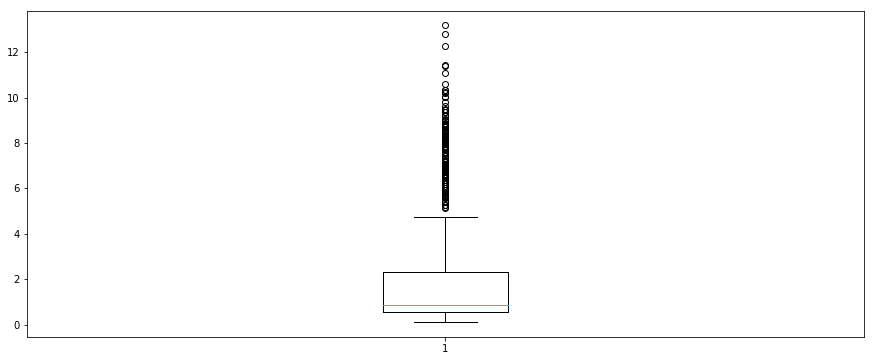

In [180]:
# Statistic about the prediction

print("mean(RMSE) = "+str(round(mean(RMS_lab),2)) +"°C")
print("min(RMSE) =  "+str(round(min(RMS_lab),2)) +"°C")
print("max(RMSE) = "+str(round(max(RMS_lab),2)) +"°C")
boxplot(RMS_lab)

**Scatter RMS temperature with label prediction**

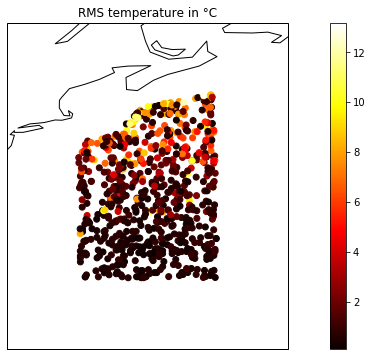

In [169]:
ax = plt.axes(projection=ccrs.PlateCarree())

CS3 =ax.scatter(lons.squeeze(),lats.squeeze(),c=RMS_lab,transform=ccrs.PlateCarree(),cmap=plt.cm.hot)
ax.set_extent([-5+min(lons), 5+max(lons), -5+min(lats),5+max(lats)])
ax.coastlines()
title("RMS temperature in °C")
plt.colorbar(CS3)
plt.show()

**Smoothes the heatmap with KNN**

100%|██████████| 26/26 [00:10<00:00,  2.51it/s]


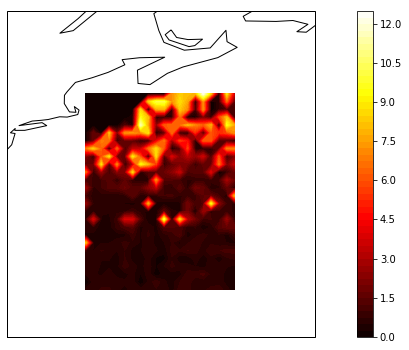

In [172]:
n_neighbors=1
x = np.arange(min(lons),max(lons), 0.5)
y = np.arange(min(lats),max(lats), 0.5)
xx, yy = np.meshgrid(x, y, sparse=True)
z = np.zeros((yy.shape[0],xx.shape[1]))
for j in tqdm(range(yy.shape[0])):
    for l in range(xx.shape[1]):
        duet =(xx[0,l],yy[j,0])
        mean_value,dist_=nearest_neighbors(duet,lng_lat,RMS_lab,n_neighbors)
        if dist_>0.5:
            z[j,l] =0
        else:
            z[j,l] =mean_value
            
ax1 = plt.axes(projection=ccrs.PlateCarree())
CS3 = plt.contourf(xx[0,:], yy[:,0], z, 60,
            transform=ccrs.PlateCarree(),cmap=plt.cm.hot)
ax1.set_extent([-5+min(lons), 5+max(lons), -3+min(lats),5+max(lats)])
ax1.coastlines()
plt.colorbar(CS3)
plt.show()

### END OF THE NOTEBOOK
### Some unsorted useful content


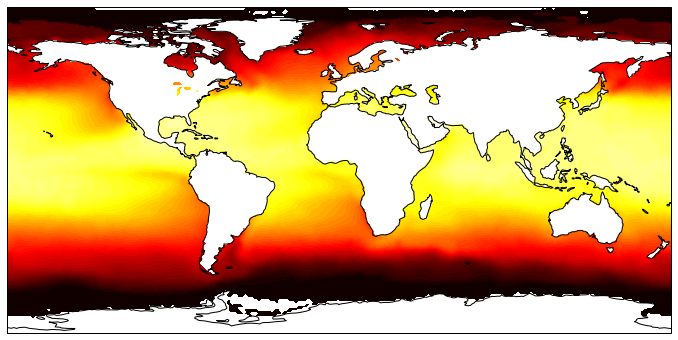

In [143]:
import os
import matplotlib.pyplot as plt
from netCDF4 import Dataset as netcdf_dataset
import numpy as np

from cartopy import config
import cartopy.crs as ccrs


# get the path of the file. It can be found in the repo data directory.
fname = os.path.join(config["repo_data_dir"],
                     'netcdf', 'HadISST1_SST_update.nc'
                     )

dataset = netcdf_dataset(fname)
sst = dataset.variables['sst'][0, :, :]
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree(),cmap=plt.cm.hot)


ax.coastlines()

plt.show()


In [48]:

### Combining result 
"""struct_list = []
for j in range(0,len(pi_hats_)):
    struct_['pi_hats_'] = pi_hats_
    struct_['nb_class'] = nb_class
    struct_['Y_orth'] = Y_orth
    struct_['index_class'] = index_class
    struct_['rpz_class'] = rpz_class
    struct_['lat_lng'] = lat_lng
    struct_['index_class'] = index_class
    struct_['j'] = j
    struct_list.append(struct_)

def assignment_geo(struct_)
    pi_hats_ = struct_['pi_hats_'] 
    nb_class = struct_['nb_class'] 
    Y_orth = struct_['Y_orth'] 
    index_class = struct_['index_class'] 
    rpz_class = struct_['rpz_class'] 
    lat_lng = struct_['lat_lng'] 
    index_class = struct_['index_class'] 
    j = struct_['j']

    new_index_class = np.argmax(pi_hats_[j][0],1)
    new_rpz_class = zeros((nb_class,Y_orth.shape[1]))
    for k in range(nb_class):
        #new_rpz_class[k,:] = np.mean(Y_orth[np.where(new_index_class==k),:].squeeze(),0)
        weight= pi_hats_[j][0][new_index_class,k].squeeze()
        vector_temp =Y_orth[new_index_class,:].squeeze()
        new_rpz_class[k,:] = sum(array([weight[ind]*vector_temp[ind,:] for ind in range(len(weight))]),0)/sum(weight)
    ground_truth_label = index_class
    estimated_label    = new_index_class
    distance_matrix    = array([[np.linalg.norm(rpz_class[i,:]-new_rpz_class[j,:]) for i in range(nb_class)] for j in range(nb_class)])                      

    geo_distance = geo_error(lat_lng,index_class,new_index_class,nb_class)
    assignment_matrix  = la.linear_assignment(geo_distance)#distance_matrix)

    new_index_class_ = zeros(len(new_index_class))
    for k in range(nb_class):
        new_index_class_[np.where(new_index_class==k)]= assignment_matrix[k][1]
    return(new_index_class_)"""

"struct_list = []\nfor j in range(0,len(pi_hats_)):\n    struct_['pi_hats_'] = pi_hats_\n    struct_['nb_class'] = nb_class\n    struct_['Y_orth'] = Y_orth\n    struct_['index_class'] = index_class\n    struct_['rpz_class'] = rpz_class\n    struct_['lat_lng'] = lat_lng\n    struct_['index_class'] = index_class\n    struct_['j'] = j\n    struct_list.append(struct_)\n\ndef assignment_geo(struct_)\n    pi_hats_ = struct_['pi_hats_'] \n    nb_class = struct_['nb_class'] \n    Y_orth = struct_['Y_orth'] \n    index_class = struct_['index_class'] \n    rpz_class = struct_['rpz_class'] \n    lat_lng = struct_['lat_lng'] \n    index_class = struct_['index_class'] \n    j = struct_['j']\n\n    new_index_class = np.argmax(pi_hats_[j][0],1)\n    new_rpz_class = zeros((nb_class,Y_orth.shape[1]))\n    for k in range(nb_class):\n        #new_rpz_class[k,:] = np.mean(Y_orth[np.where(new_index_class==k),:].squeeze(),0)\n        weight= pi_hats_[j][0][new_index_class,k].squeeze()\n        vector_temp =